# Segmentation Performance
Evaluation of membrane detection using watershed/variation of information (VI) and pixel-wise membrane error. Variation of Information is calculated using [partition_comparison](https://github.com/thouis/partition-comparison) and split VI is calculated using [gala](https://github.com/janelia-flyem/gala).

In [1]:
%matplotlib inline
import mahotas as mh
import cPickle
from gala import evaluate as ev
import numpy as np
import partition_comparison
import matplotlib.pyplot as plt

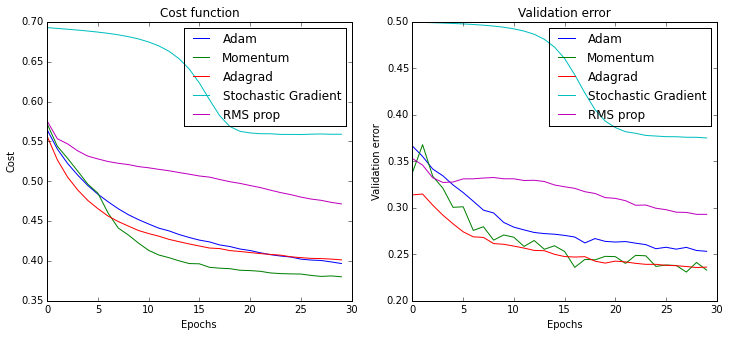

In [2]:
address = "../results/optimizers/"
results_sgdm = np.load(address + "results_adam/results.npy")
results_mom = np.load(address + "results_mom/results.npy")
results_adagrad = np.load(address + "results_adagrad/results.npy")
results_sgd = np.load(address + "results_sgd/results.npy")
results_rmsprop = np.load(address + "results_rmsprop/results.npy")

plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)
ax1.plot(results_sgdm[0],label="Adam")
ax1.plot(results_mom[0],label="Momentum")
ax1.plot(results_adagrad[0],label="Adagrad")
ax1.plot(results_sgd[0],label="Stochastic Gradient")
ax1.plot(results_rmsprop[0],label="RMS prop")
ax1.set_title("Cost function")
ax1.legend(loc=1)
plt.xlabel("Epochs")
plt.ylabel("Cost")

ax2 = plt.subplot(1,2,2)
ax2.plot(results_sgdm[1],label="Adam")
ax2.plot(results_mom[1],label="Momentum")
ax2.plot(results_adagrad[1],label="Adagrad")
ax2.plot(results_sgd[1],label="Stochastic Gradient")
ax2.plot(results_rmsprop[1],label="RMS prop")
ax2.set_title("Validation error")
ax2.legend(loc=1)
plt.xlabel("Epochs")
plt.ylabel("Validation error")

In [3]:
def disk(radius):
    y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
    return x**2 + y**2 <= radius**2


def watershed(probs, radius):
    sel = disk(radius)
    minima = mh.regmin(probs, Bc=sel)
    markers, nr_markers = mh.label(minima)
    return mh.cwatershed(probs, markers)

def partition_VI(putative, gold):
    mask = gold != 0
    VI_res = partition_comparison.variation_of_information(gold[mask], putative[mask].astype(gold.dtype))
    return VI_res

def evaluate_VI(pred,ground_truth,radii):

    if radii.size >1:
        VI = np.zeros((radii.size,3))
        r = 0
        for radius in radii:
            # VI_metric -> undersegmentation error,oversegmentation error,VI

            segmentation = watershed(pred,radius)
            VI_split =  ev.split_vi(segmentation, ground_truth)
            VI[r,0] += VI_split[0]
            VI[r,1] += VI_split[1]

            VI_partition = partition_VI(segmentation, ground_truth)    
            VI[r,2] += VI_partition   

            r += 1
    else:
        try:
            segmentation = watershed(pred,radii[0])
            VI = partition_VI(segmentation, ground_truth) 
        except:
            segmentation = watershed(pred,radii)
            VI = partition_VI(segmentation, ground_truth)
    
    return VI

def remove_synapse(img, threshold = 399):  
    for m in xrange(img.shape[0]):
        for n in xrange(img.shape[1]):
            if img[m,n] > threshold:
                img[m,n] = 0
    return img

def find_min(VI):
    # Find minimum VI value
    VI_min_pos = np.argmin(VI[:,2])
    return VI[VI_min_pos], VI_min_pos
    

### Calculate VI/Error
VI truth is the estimated VI for the membrane edges that are used as ground truth and represent the loss going from segmentation to edges and back. 

In [5]:
address = "../results/optimizers/"

address_adam =  address + "results_adam/"
pred_adam          = np.load(address_adam + "output.npy")
y                  = np.load(address_adam + "y.npy")
pred_window_size  = np.load(address_adam + "pred_window_size.npy")
gap1 = (pred_window_size[0]-pred_window_size[1])/2

address_mom =  address + "results_mom/"
pred_mom          = np.load(address_mom + "output.npy")

address_adagrad =  address + "results_adagrad/"
pred_adagrad          = np.load(address_adagrad + "output.npy")

address_sgd=  address + "results_sgd/"
pred_sgd          = np.load(address_sgd + "output.npy")

address_rmsprop=  address + "results_rmsprop/"
pred_rmsprop          = np.load(address_rmsprop + "output.npy")

# Load in test-addresses
f = file(address + "/pre_processed/" + "test_adress.dat", 'rb')
test_address = cPickle.load(f)
f.close()

radii = np.linspace(7, 85, 30)
VI_adam     = np.zeros((radii.size,3))
VI_mom      = np.zeros((radii.size,3))
VI_adagrad  = np.zeros((radii.size,3))
VI_rmsprop  = np.zeros((radii.size,3))
VI_sgd  = np.zeros((radii.size,3))

n = 0
for address_img in test_address:
    ground_truth = mh.imread("../" + address_img)
    ground_truth = ground_truth[gap1:-gap1,gap1:-gap1]
    ground_truth = ground_truth.astype(np.uint16) 
    VI_adam       += evaluate_VI(pred_adam[n,0],ground_truth,radii)
    VI_mom        += evaluate_VI(pred_mom[n,0],ground_truth,radii)
    VI_adagrad    += evaluate_VI(pred_adagrad[n,0],ground_truth,radii)
    VI_rmsprop    += evaluate_VI(pred_rmsprop[n,0],ground_truth,radii)
    VI_sgd        += evaluate_VI(pred_sgd[n,0],ground_truth,radii)
    
    n += 1
    
# Average VI
VI_adam        /= float(n) 
VI_mom         /= float(n)
VI_adagrad     /= float(n) 
VI_sgd        /= float(n) 
VI_rmsprop        /= float(n) 

print "Finshed VI/watershed"

# Calculate min VI
VI_min_adam,min_index = find_min(VI_adam)
VI_min_mom,min_index = find_min(VI_mom)
VI_min_adagrad,min_index = find_min(VI_adagrad)
VI_min_sgd,min_index = find_min(VI_sgd)
VI_min_rmsprop,min_index = find_min(VI_rmsprop)

# Calculate pixel erro
pixel_error_adam = np.mean(np.abs(pred_adam-y))
pixel_error_mom = np.mean(np.abs(pred_mom-y))
pixel_error_adagrad = np.mean(np.abs(pred_adagrad-y))
pixel_error_sgd = np.mean(np.abs(pred_sgd-y))
pixel_error_rmsprop = np.mean(np.abs(pred_rmsprop-y))

# Estimate Ideal VI
radii_min = np.array([radii[min_index]],dtype=np.int32)

VI_truth = evaluate_VI(y[-1,0],ground_truth,radii_min)
print "Estimated VI Truth:", VI_truth

 Finshed VI/watershed
Estimated VI Truth: 0.150806472725


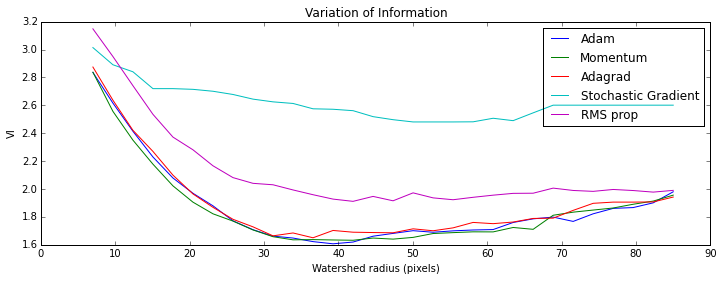

In [14]:
plt.figure(figsize=(12,4))
plt.title("Variation of Information")
plt.xlabel("Watershed radius (pixels)")
plt.ylabel("VI")
plt.plot(radii,VI_adam[:,2],label="Adam")
plt.plot(radii,VI_mom[:,2],label="Momentum")
plt.plot(radii,VI_adagrad[:,2],label="Adagrad")
plt.plot(radii,VI_sgd[:,2],label="Stochastic Gradient")
plt.plot(radii,VI_rmsprop[:,2],label="RMS prop")
plt.legend(loc="best")


plt.savefig("optimizers_VI.png")

### Best Segmentation Performance, Adam

In [7]:
print "Variation of Information (VI):",VI_min_adam[2]
print "VI, undersegmentation error:", VI_min_adam[0]
print "VI, oversegmentation error:", VI_min_adam[1]
print "Pixel-wise error:", pixel_error_adam

Variation of Information (VI): 1.60713284214
VI, undersegmentation error: 0.963027834957
VI, oversegmentation error: 1.35557474645
Pixel-wise error: 0.247817677431


### Best Segmentation Performance, Momentum

In [8]:
print "Variation of Information (VI):",VI_min_mom[2]
print "VI, undersegmentation error:", VI_min_mom[0]
print "VI, oversegmentation error:", VI_min_mom[1]
print "Pixel-wise error:", pixel_error_mom

Variation of Information (VI): 1.63246362942
VI, undersegmentation error: 1.02316112098
VI, oversegmentation error: 1.33198606161
Pixel-wise error: 0.230922916882


### Best Segmentation Performance, Adagrad

In [9]:
print "Variation of Information (VI):",VI_min_adagrad[2]
print "VI, undersegmentation error:", VI_min_adagrad[0]
print "VI, oversegmentation error:", VI_min_adagrad[1]
print "Pixel-wise error:", pixel_error_adagrad

Variation of Information (VI): 1.65032412567
VI, undersegmentation error: 0.857900805724
VI, oversegmentation error: 1.52301362624
Pixel-wise error: 0.236099807567


### Best Segmentation Performance, RMS prop

In [10]:
print "Variation of Information (VI):",VI_min_rmsprop[2]
print "VI, undersegmentation error:", VI_min_rmsprop[0]
print "VI, oversegmentation error:", VI_min_rmsprop[1]
print "Pixel-wise error:", pixel_error_rmsprop

Variation of Information (VI): 1.91151528207
VI, undersegmentation error: 1.27866088171
VI, oversegmentation error: 1.47907273632
Pixel-wise error: 0.292311948713


### Best Segmentation Performance, Stochastic Gradient

In [11]:
print "Variation of Information (VI):",VI_min_sgd[2]
print "VI, undersegmentation error:", VI_min_sgd[0]
print "VI, oversegmentation error:", VI_min_sgd[1]
print "Pixel-wise error:", pixel_error_sgd

Variation of Information (VI): 2.48071867703
VI, undersegmentation error: 2.24785207847
VI, oversegmentation error: 1.33106845473
Pixel-wise error: 0.366801324756


### Example pictures

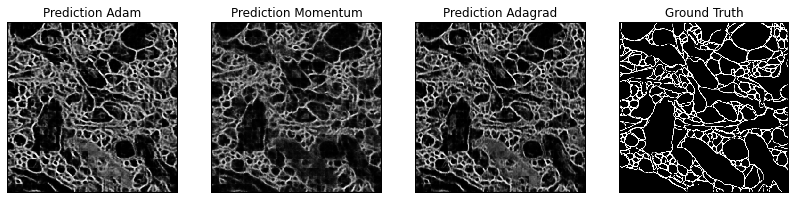

In [12]:
plt.figure(figsize=(14,5))
for n in xrange(y.shape[0]):

    ax1 = plt.subplot(1,4,1)
    ax1.set_title("Prediction Adam")
    plt.imshow(pred_adam[n,0],cmap=plt.cm.gray)
    ax1.grid(True)
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    
    ax1 = plt.subplot(1,4,2)
    ax1.set_title("Prediction Momentum")
    plt.imshow(pred_mom[n,0],cmap=plt.cm.gray)
    ax1.grid(True)
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    
    ax1 = plt.subplot(1,4,3)
    ax1.set_title("Prediction Adagrad")
    plt.imshow(pred_adagrad[n,0],cmap=plt.cm.gray)
    ax1.grid(True)
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])

    ax3 = plt.subplot(1,4,4)
    ax3.set_title("Ground Truth")
    plt.imshow(y[n,0],cmap=plt.cm.gray)
    ax3.grid(True)
    ax3.set_xticklabels([])
    ax3.set_yticklabels([])
    
    plt.savefig("optimizer_example_" + str(n))